<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#88d8b0; font-size:40px'>5.1 Classification Model - Cyberbullying vs Not Cyberbullying (Hold Out) </h1>
</div>

<div class="alert alert-info" style="background-color:#88d8b0; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Import Libraries or Modules </h2>
</div>

In [1]:
# Import Dependencies
# %matplotlib inline

# Begin Python Imports
import datetime, warnings, scipy
warnings.filterwarnings("ignore")
import pickle
import os
import glob

# Data Manipulation
import numpy as np
import pandas as pd
from scipy import sparse
pd.set_option('display.max_columns', None)

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    StratifiedShuffleSplit,
    GridSearchCV,
    cross_val_score
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score, 
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    plot_confusion_matrix,
    plot_precision_recall_curve
)

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MaxAbsScaler
from collections import Counter

<div class="alert alert-info" style="background-color:#88d8b0; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Plot Confuxion Matrix Function</h2>
</div>

In [2]:
#########################
# Plot Confusion Matrix #
#########################
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

<div class="alert alert-info" style="background-color:#88d8b0; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Train and Test Classifier</h2>
</div>

In [3]:
# Instantiate classifier
scaler = MaxAbsScaler()

lr = LogisticRegression(n_jobs=-1)
svc = LinearSVC(random_state=1127)

In [4]:
##############################
# Train and Test Classifiers #
##############################
def automate_result(df='bully_data_clean_with_stopword',sampling='original',sampling_ratio=1):
    
    ####################
    # Reset Processing #
    ####################
    # first check whether file exists or not
    # calling remove method to delete the csv file
    # in remove method you need to pass file name and type
    
    task = 'bully_binary_classification'
    file = task + '/' + df + '/results/results_' + sampling + str(sampling_ratio) + '_sample_holdout.csv'
    #file = df + '/results/results_all.csv'
    if(os.path.exists(file) and os.path.isfile(file)):
        os.remove(file)
        print("File deleted")
    else:
        print("File cleared")
     
    
    ########################
    # Train and Test Model #
    ########################
    # Note    
    # classifier_name and pipeline
    # feature_name and X
    
    def run_model(classifier_name, feature_name, splits, X, Y, pipeline, average_method,target_label):
        
        # Instantiate 
        accuracy = []
        precision = []
        recall = []
        f1 = []
        auc = []
        
        record_cols = ["sampling_method","classifier","feature",
                       "accuracy",
                       "precision",
                       "recall",
                       "f1",
                       "auc"]
        
        # Run Train-test spilt
        X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.1, random_state=1127, stratify=Y)   
        print("["+ sampling + ", " + classifier_name + "] Developing Model and Generating Metrics for features: " + feature_name)
        
        # Train and fit model
        model_fit = pipeline.fit(X_train, Y_train)
        prediction = model_fit.predict(X_test)

        # Compute metrics
        scores = model_fit.score(X_test,Y_test)
        accuracy.append(scores * 100)
        if target_label == None:
            precision.append(precision_score(Y_test, prediction, average=average_method)*100)
            recall.append(recall_score(Y_test, prediction, average=average_method)*100)
            f1.append(f1_score(Y_test, prediction, average=average_method)*100)
            auc.append(roc_auc_score(Y_test, model_fit.decision_function(X_test), average=None)*100)
        else:
            precision.append(precision_score(Y_test, prediction, average=average_method, pos_label=target_label)*100)
            recall.append(recall_score(Y_test, prediction, average=average_method, pos_label=target_label)*100)
            f1.append(f1_score(Y_test, prediction, average=average_method, pos_label=target_label)*100)
            auc.append(roc_auc_score(Y_test, model_fit.decision_function(X_test), average=None)*100)

        record = zip([sampling],
                     [classifier_name], [feature_name],
                     [accuracy],
                     [precision],        
                     [recall],               
                     [f1],             
                     [auc]              
                    ) 

        df = pd.DataFrame(record, columns=record_cols)
        df.to_csv(file,mode='a', header=(index==0))
        
        
        ####################
        # Confusion Matrix #
        ####################
        
        conf_mat = confusion_matrix(Y_test,prediction)
        categories = ['Cyberbullying','Non-Cyberbullying']
        labels = ['True Positive','',
                '','True Negative']

        make_confusion_matrix(conf_mat, 
                            group_names=labels,
                            categories=categories, 
                            figsize=(8,5), 
                            cbar=True, 
                            title='Fine Tuned ' + classifier + ' for Cyberbullying Detection', 
                            cmap='YlGnBu', 
                            sum_stats=False)
        
        
    #########################
    # Classifier Dictionary #
    #########################

    classifier_dict = { 'LogisticRegression': lr,
                        'LibSVC': svc
                        }
    
    
    #######################
    # Features Dictionary #
    #######################
    # Load Pickle files for X feature vectors
    
    path = task + '\\' + df + '\\features\\selected'
    all_files = glob.glob(path + "/X*.pkl")
    feature_dict = {}

    for file_ in all_files:
        # temp = file_.split('\\')[-1].split('.')[0]
        temp = file_.split('\\')[-1].split('.')[0].split("_")[-1] # e.g X_AllTextual.pkl
        
        with open(file_,'rb') as f:
            x = pickle.load(f)
            feature_dict[temp]  = x
    
    
    ################
    # Target Label #
    ################
    # Load Pickle file for Y label
    
    with open(task + '\\' + df + '\\target_class\\Y_cyberbullying.pkl','rb') as f:
        Y_label = pickle.load(f)
    
    
    ########################
    # Run through the loop #
    ########################
   
    index = 0 # Initialization
    for classifier in classifier_dict.keys():
        
        # Selection of Pipeline by sampling method 
        if sampling == "original":
            selected_pipeline = Pipeline([
                                          ('scaler',scaler),
                                          ('classifier', classifier_dict[classifier])])

        elif sampling == "oversampling":
            selected_pipeline =  make_pipeline(
                                               scaler,
                                               RandomOverSampler(random_state=1127,sampling_strategy=sampling_ratio),
                                               classifier_dict[classifier])
            
        elif sampling == "smote":
            selected_pipeline =  make_pipeline(
                                               scaler,
                                               SMOTE(random_state=1127,sampling_strategy=sampling_ratio),

                                               classifier_dict[classifier])     
        elif sampling == "downsampling":
            selected_pipeline = make_pipeline(
                                              scaler,
                                              RandomUnderSampler(random_state=1127,sampling_strategy=sampling_ratio),
                                              classifier_dict[classifier])

        for feature in tqdm(feature_dict.keys()):
            X_feature = feature_dict[feature]
            run_model(classifier_name=classifier, 
                      feature_name=feature, 
                      splits=None, 
                      X=X_feature, 
                      Y=Y_label, 
                      pipeline = selected_pipeline, 
                      average_method = 'binary', # macro for multiclass, binary for binary classification
                      target_label = "Cyberbullying") # Specify Cyberbullying for binary classification
            index = index + 1
            print()

File cleared


  0%|          | 0/4 [00:00<?, ?it/s]

[original, LogisticRegression] Developing Model and Generating Metrics for features: CountVecWordCharAllTextStatDistilBertEmbeddingPycholinguisticLIWC22EmpathTermListsRatioToxicityMBTI


 25%|██▌       | 1/4 [02:10<06:31, 130.62s/it]


[original, LogisticRegression] Developing Model and Generating Metrics for features: CountVecWordCharAllTextStatSentimentAllDistilBertEmbeddingPycholinguisticLIWC22EmpathTermListsRatioMBTI


 50%|█████     | 2/4 [03:30<03:22, 101.06s/it]


[original, LogisticRegression] Developing Model and Generating Metrics for features: CountVecWordCharAllTextStatSentimentAllDistilBertEmbeddingPycholinguisticLIWC22EmpathTermListsRatioToxicityMBTI


 75%|███████▌  | 3/4 [04:35<01:24, 84.16s/it] 


[original, LogisticRegression] Developing Model and Generating Metrics for features: CountVecWordCharAllTextStatSentimentAllDistilBertEmbeddingPycholinguisticLIWC22EmpathToxicityMBTI


100%|██████████| 4/4 [05:29<00:00, 82.45s/it]

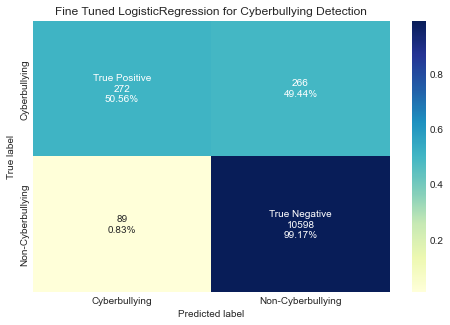

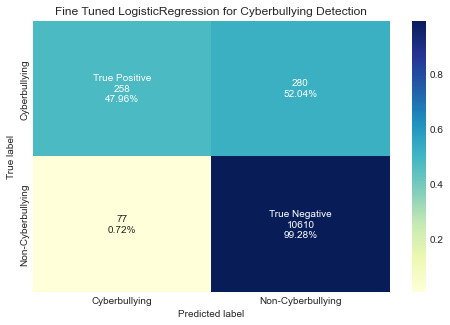

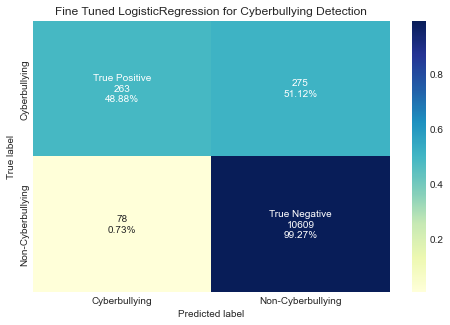

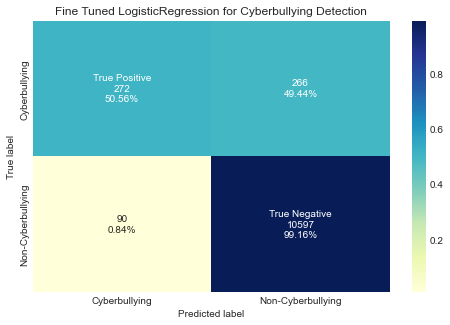

In [5]:
############################################
# Data 1: 'bully_data_clean_with_stopword'
############################################

automate_result(df='bully_data_clean_with_stopword',sampling='original')

File cleared


  0%|          | 0/1 [00:00<?, ?it/s]

[smote, LibSVC] Developing Model and Generating Metrics for features: CountVecWordCharAllTextStatSentimentAllDistilBertEmbeddingToxicity


100%|██████████| 1/1 [02:46<00:00, 166.62s/it]

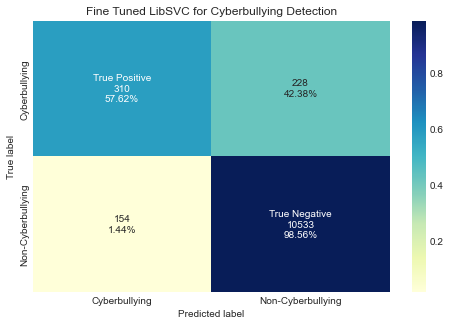

In [5]:
automate_result(df='bully_data_clean_with_stopword',sampling='smote',sampling_ratio=0.15)